Split testing verification - if everything is functioning correctly, statistically significant differences between two groups were obtained in less than 5% of cases out of 10,000 A/A tests.  
I will create a simulation of 10,000 A/A tests with a subsample of 500 users.

Tasks:  
1.Make a histogram representing the distribution of the 10,000 p-values.  
2.Calculate the percentage of p-values that are less than or equal to 0.05.  
3.Write a conclusion.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse 
%matplotlib inline

In [2]:
connection = {'host': '***',
                      'database':'***',
                      'user':'***', 
                      'password':'***'
                     }

In [3]:
#creating a functionn to simplify the workflow
def select(sql):
    
    table = pandahouse.read_clickhouse(sql, connection=connection)
    return table

In [4]:
#extracting the data and save it to a dataset.
sql = '''

SELECT  user_id,
        toDate(time) as date,
        gender,
        age,
        os,
        source,
        country,
        exp_group,
        countIf(action = 'like') / countIf(action = 'view') as ctr
        
FROM {db}.feed_actions 
WHERE exp_group in (2,3)  AND 
                        (toDate(time) >= '2023-03-25' and toDate(time) <= '2023-03-31' )
GROUP BY user_id, 
         date,
         gender,
         age,
         os,
         source,
         country,
         exp_group
ORDER BY date

'''

exp_groups = select(sql)
exp_groups.head()

,user_id,date,gender,age,os,source,country,exp_group,ctr
0,118799,2023-03-25,1,20,Android,organic,Russia,2,0.025316
1,3852,2023-03-25,1,16,Android,ads,Russia,2,0.166667
2,123634,2023-03-25,1,32,Android,organic,Russia,2,0.145833
3,117987,2023-03-25,1,56,Android,organic,Russia,2,0.226415
4,7428,2023-03-25,1,20,Android,ads,Russia,2,0.120000


# AA-test

In [5]:
#creating a list to save the p-values.
p_values=[]

In [17]:
#A loop to repeat 10,000 times.
for i in range(10000):
    # selecting 500 random users
    group2 = exp_groups.query('exp_group == 2').sample(500, replace=False)
    group3 = exp_groups.query('exp_group == 3').sample(500, replace=False)
    sample=pd.concat([group2,group3])
    #t-test
    t, p = ttest_ind(group2['ctr'], group3['ctr'], equal_var=False)
    #adding the p-value to the previously created list
    p_values.append(p)

<AxesSubplot:ylabel='Count'>

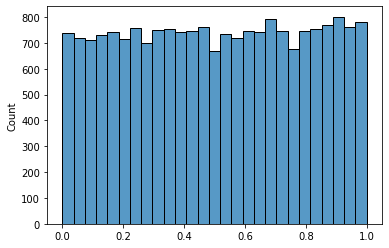

In [18]:
#plot the distribution histogram 
sns.histplot(data=p_values)

In [24]:
#calculate the percentage of p-values that are less than or equal to alpha
count_pv = 0
for i in p_values:
    if i <= 0.05:
        count_pv += 1
share = round(count_pv * 100 / len(p_values), 2)
share

4.92

## Creating and analyzing a graph for the A/A test. 

In [25]:
exp_groups.groupby('exp_group').count()

,user_id,date,gender,age,os,source,country,ctr
exp_group,,,,,,,,
2,16905,16905,16905,16905,16905,16905,16905,16905
3,17232,17232,17232,17232,17232,17232,17232,17232


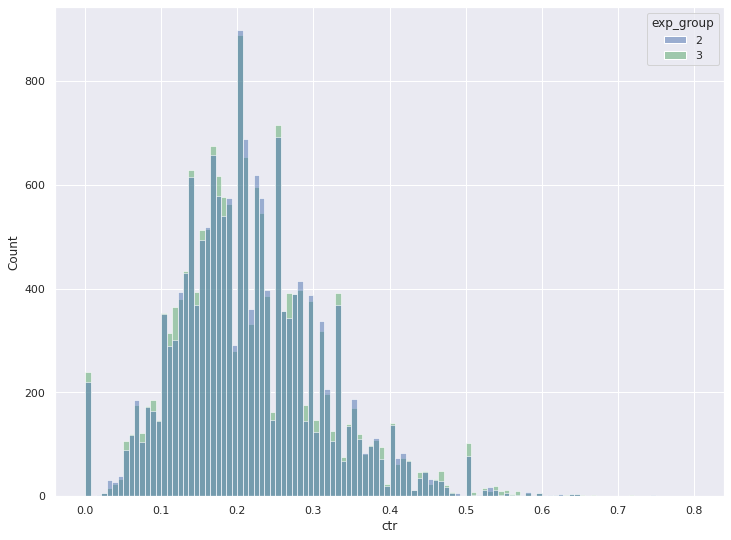

In [30]:
sns.set(rc={'figure.figsize': (12, 9)})
exp_groups_graph = sns.histplot(data=exp_groups , 
                                x='ctr', 
                                hue='exp_group',
                                palette=['b', 'g'],
                                alpha=0.5,
                                kde=False)

# Conclusion:
After calculating the p-value and comparing it with the alpha value, it became clear that statistically significant differences between the two groups were found in 4.92% of cases out of 10,000. Overall, it can be concluded that the system is functioning correctly, and the results of the A/A test can be trusted.
  
The distribution analysis of the graph revealed that the distribution is similar to a normal distribution and comparable between the groups.